In [14]:
pip install opencv-python

In [15]:
import numpy as np
from scipy.stats import norm
import cv2 as cv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Utils

In [17]:
moyyy1 = []
moyyy2 = []
siiig1 = []
siiig2 = []
ppp1 = []
ppp2 = []

In [18]:
import numpy as np
from math import log2, sqrt
from scipy.stats import norm


def get_line_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction ne fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    """
    return [a.flatten() for a in np.indices((dSize, dSize))]


def line_transform_img(img):
    """
    Cette fonction prend une image carrée en entrée, et retourne l'image applatie (1 dimension) selon le parcours ligne par ligne
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    idx = get_line_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_line_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours ligne par ligne
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_line_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img


def get_peano_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
    selon la courbe de Hilbert-Peano
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours de Hilbert-Peano
    """
    assert log2(dSize).is_integer(), 'veuillez donne une dimension étant une puissance de 2'
    xTmp = 0
    yTmp = 0
    dirTmp = 0
    dirLookup = np.array(
        [[3, 0, 0, 1], [0, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 0], [1, 0, 0, 3], [2, 1, 1, 0], [3, 2, 2, 1],
         [0, 3, 3, 2]]).T
    dirLookup = dirLookup + np.array(
        [[4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [0, 4, 4, 0], [0, 4, 4, 0], [0, 4, 4, 0],
         [0, 4, 4, 0]]).T
    orderLookup = np.array(
        [[0, 2, 3, 1], [1, 0, 2, 3], [3, 1, 0, 2], [2, 3, 1, 0], [1, 3, 2, 0], [3, 2, 0, 1], [2, 0, 1, 3],
         [0, 1, 3, 2]]).T
    offsetLookup = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
    for i in range(int(log2(dSize))):
        xTmp = np.array([(xTmp - 1) * 2 + offsetLookup[0, orderLookup[0, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[1, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[2, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[3, dirTmp]] + 1])

        yTmp = np.array([(yTmp - 1) * 2 + offsetLookup[1, orderLookup[0, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[1, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[2, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[3, dirTmp]] + 1])

        dirTmp = np.array([dirLookup[0, dirTmp], dirLookup[1, dirTmp], dirLookup[2, dirTmp], dirLookup[3, dirTmp]])

        xTmp = xTmp.T.flatten()
        yTmp = yTmp.T.flatten()
        dirTmp = dirTmp.flatten()

    x = - xTmp
    y = - yTmp
    return x, y


def peano_transform_img(img):
    """
    Cette fonction prend une image carrée (dont la dimension est une puissance de 2) en entrée,
    et retourne l'image applatie (1 dimension) selon le parcours de Hilbert-Peano
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    assert log2(img.shape[0]).is_integer(), 'veuillez donne rune image dont la dimension est une puissance de 2'
    idx = get_peano_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_peano_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours de Hilbert-Peano
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_peano_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img


def MPM_gm(Y,cl1,cl2,p1,p2,m1,sig1,m2,sig2):
    """
    Cette fonction permet d'appliquer la méthode mpm pour retrouver notre signal d'origine à partir de sa version bruité et des paramètres du model.
    :param Y: tableau des observations bruitées
    :param cl1: Valeur de la classe 1
    :param cl2: Valeur de la classe 2
    :param p1: probabilité d'apparition a priori pour la classe 1
    :param p2: probabilité d'apparition a priori pour la classe 2
    :param m1: La moyenne de la première gaussienne
    :param sig1: L'écart type de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: L'écart type de la deuxième gaussienne
    :return: Un signal discret à 2 classe (numpy array 1D d'int)
    """
    return np.where((p1*norm.pdf(Y, m1, sig1)) > (p2*norm.pdf(Y, m2,sig2)), cl1, cl2)


def calc_param_EM_gm(Y, p1, p2, m1, sig1, m2, sig2):
    """
    Cette fonction permet de calculer les nouveaux paramètres estimé pour une itération de EM
    :param Y: tableau des observations bruitées
    :param p1: probabilité d'apparition a priori pour la classe 1
    :param p2: probabilité d'apparition a priori pour la classe 2
    :param m1: La moyenne de la première gaussienne
    :param sig1: L'écart type de la première gaussienne
    :param m2: La moyenne de la deuxième gaussienne
    :param sig2: L'écart type de la deuxième gaussienne
    :return: tous les paramètres réestimés donc p1, p2, m1, sig1, m2, sig2
    """

    calc_apost1 = p1*norm.pdf(Y, m1, sig1)
    calc_apost2 = p2*norm.pdf(Y, m2, sig2)
    proba_apost1 = calc_apost1 / (calc_apost1 + calc_apost2)
    proba_apost2 = calc_apost2 / (calc_apost1 + calc_apost2)
    p1 = proba_apost1.sum() / Y.shape[0]
    p2 = proba_apost2.sum() / Y.shape[0]
    m1 = (proba_apost1 * Y).sum() / proba_apost1.sum()
    sig1 = np.sqrt((proba_apost1 * ((Y - m1) ** 2)).sum() / proba_apost1.sum())
    m2 = (proba_apost2 * Y).sum() / proba_apost2.sum()
    sig2 = np.sqrt((proba_apost2 * ((Y - m2) ** 2)).sum() / proba_apost2.sum())
    return p1, p2, m1, sig1, m2, sig2


def estim_param_EM_gm(iter, Y, p1, p2, m1, sig1, m2, sig2):
    """
    Cette fonction est l'implémentation de l'algorithme EM pour le modèle en question
    :param iter: Nombre d'itération choisie
    :param Y: tableau des observations bruitées
    :param p1: valeur d'initialisation de la probabilité d'apparition a priori pour la classe 1
    :param p2: valeur d'initialisation de la probabilité d'apparition a priori pour la classe 2
    :param m1: la valeur d'initialisation de la moyenne de la première gaussienne
    :param sig1: la valeur d'initialisation de l'écart type de la première gaussienne
    :param m2: la valeur d'initialisation de la moyenne de la deuxième gaussienne
    :param sig2: la valeur d'initialisation de l'écart type de la deuxième gaussienne
    :return: Tous les paramètres réestimés à la fin de l'algorithme EM donc p1, p2, m1, sig1, m2, sig2
    """
    p1_est = p1
    p2_est = p2
    m1_est = m1
    sig1_est = sig1
    m2_est = m2
    sig2_est = sig2
    for i in range(iter):
        p1_est, p2_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_gm(Y, p1_est, p2_est, m1_est, sig1_est, m2_est,
                                                                     sig2_est)
        #print({'p1': p1_est,'p2': p2_est, 'm1': m1_est, 'sig1': sig1_est, 'm2': m2_est, 'sig2': sig2_est})
        moyyy1.append(m1_est)
        moyyy2.append(m2_est)
        siiig1.append(sig1_est)
        siiig2.append(sig2_est)
        ppp1.append(p1_est)
        ppp2.append(p2_est)

    return p1_est, p2_est, m1_est, sig1_est, m2_est, sig2_est


#Modèles des couples indépendants


##Premières fonctions


In [19]:
def bruit_gauss2(X,cl1,cl2,m1,sig1,m2,sig2):
  Y = np.zeros(X.shape[0])
  Y[X==cl1]=sig1*np.random.randn(Y[X==cl1].shape[0])+m1
  Y[X==cl2]=sig2*np.random.randn(Y[X==cl2].shape[0])+m2
  return Y
 # return ((X==cl1)*(m1+np.random.randn(*X.shape)*sig1)+(X==cl2)*(m2+np.random.randn(*X.shape)*sig2))

In [20]:
def taux_erreur(A,B):
  return np.count_nonzero(A != B) / A.size

In [21]:
def calc_probaprio2(X,cl1,cl2):
  p1 = np.sum((X == cl1)) / X.shape[0]
  p2 = np.sum((X == cl2)) / X.shape[0]
  return np.array([p1,p2])

##Deuxièmes fonctions


In [22]:
def seg_image_indep(iter, imaj, m1, sig1, m2, sig2):
  counts, _ = np.histogram(imaj, bins=int(imaj.max()+1), range=(0,int(imaj.max())))
  cl1, cl2 = np.nonzero(counts)[0]
  imaj_line = line_transform_img(imaj)
  imaj_line_noise = bruit_gauss2(imaj_line, cl1, cl2, m1, sig1, m2, sig2)
  p1, p2 = calc_probaprio2(imaj_line,cl1, cl2)

  kmeans = KMeans(n_clusters=2)
  kmeans.fit(imaj_line_noise.reshape(-1,1))
  imaj_segment = kmeans.labels_
  moyennes = kmeans.cluster_centers_
  X0 = imaj_line_noise[imaj_segment==0]
  X1 = imaj_line_noise[imaj_segment==1]
  n0 = X0.shape[0]
  n1 = X1.shape[0]
  mom2 = np.array([(1/n0) * np.sum(X0**2), (1/n1) * np.sum(X1**2)])
  sigs = np.array([np.sqrt(mom2[0] - moyennes[0]), np.sqrt(mom2[1] - moyennes[1])])
  
  p1_est, p2_est, m1_est, sig1_est, m2_est, sig2_est = estim_param_EM_gm(iter, 
                                                                         imaj_line_noise, 
                                                                         p1, p2, 
                                                                         moyennes[0][0], sigs[0], 
                                                                         moyennes[1][0], sigs[1])
  segmented_img_ligne = MPM_gm(imaj_line_noise, cl1, cl2, p1_est, p2_est, m1_est, sig1_est, m2_est, sig2_est)
  img_bruitee = transform_line_in_img(imaj_line_noise, imaj.shape[0])
  segmented_img = transform_line_in_img(segmented_img_ligne, imaj.shape[0])
  
  # Partie Affichage
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
  axes[0].matshow(imaj,cmap='gray')
  axes[0].set_title('Image')
  axes[2].matshow(segmented_img,cmap='gray')
  axes[2].set_title('Image segmentée')
  axes[1].matshow(img_bruitee,cmap='gray')
  axes[1].set_title('Image bruitée')

  print("Taux d'erreur entre l'image réelle et l'image segmentée = "+str(taux_erreur(imaj_line,segmented_img_ligne)))

In [23]:
beee = cv.cvtColor(cv.imread('/content/drive/MyDrive/Wojciech/Segmentationimage/beee2.bmp'),cv.COLOR_BGR2GRAY)
veau = cv.cvtColor(cv.imread('/content/drive/MyDrive/Wojciech/Segmentationimage/veau2.bmp'),cv.COLOR_BGR2GRAY)
zebre = cv.cvtColor(cv.imread('/content/drive/MyDrive/Wojciech/Segmentationimage/zebre2.bmp'),cv.COLOR_BGR2GRAY)
m1 = [0, 1, 0]
sig1 = [1, 1, 1]
m2 = [3, 1, 1]
sig2 = [2, 5, 1]
ite = 100

Taux d'erreur entre l'image réelle et l'image segmentée = 0.8943634033203125
Taux d'erreur entre l'image réelle et l'image segmentée = 0.118194580078125
Taux d'erreur entre l'image réelle et l'image segmentée = 0.25335693359375


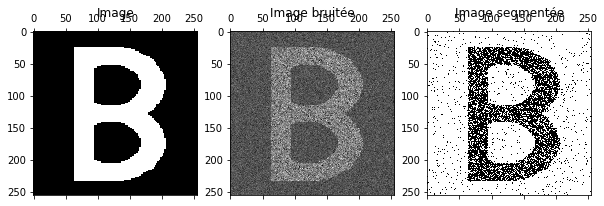

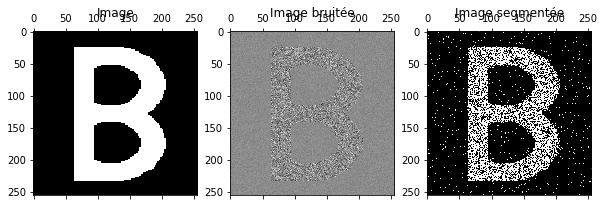

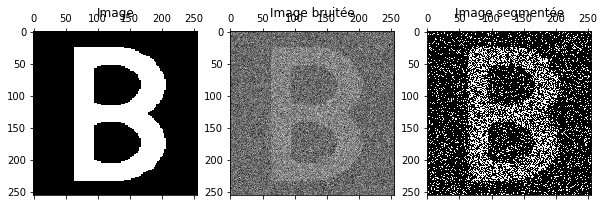

In [24]:
for j in range(3):
  seg_image_indep(ite, beee, m1[j], sig1[j], m2[j], sig2[j])

Taux d'erreur entre l'image réelle et l'image segmentée = 0.1486968994140625
Taux d'erreur entre l'image réelle et l'image segmentée = 0.1790924072265625
Taux d'erreur entre l'image réelle et l'image segmentée = 0.6892547607421875


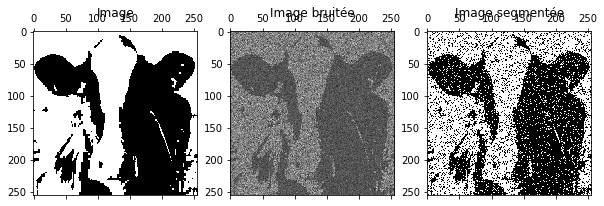

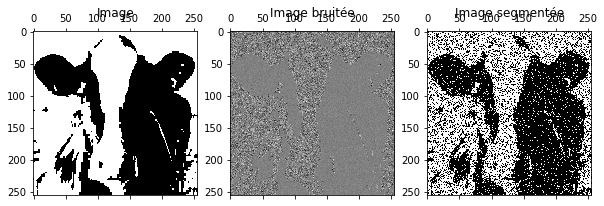

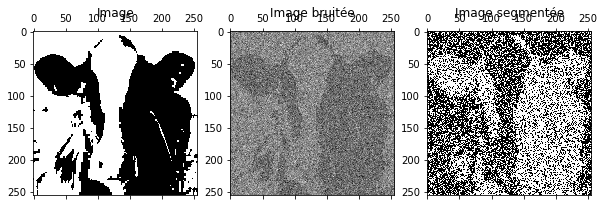

In [25]:
for j in range(3):
  seg_image_indep(ite, veau, m1[j], sig1[j], m2[j], sig2[j])

Taux d'erreur entre l'image réelle et l'image segmentée = 0.8647003173828125
Taux d'erreur entre l'image réelle et l'image segmentée = 0.8427886962890625
Taux d'erreur entre l'image réelle et l'image segmentée = 0.3033599853515625


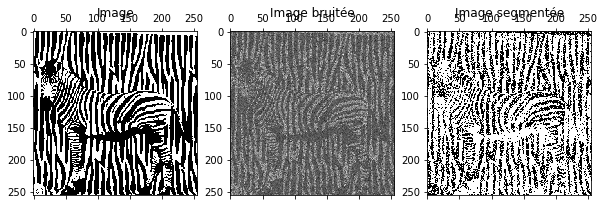

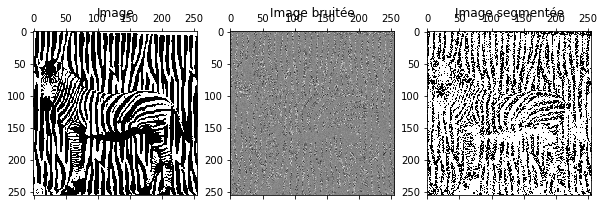

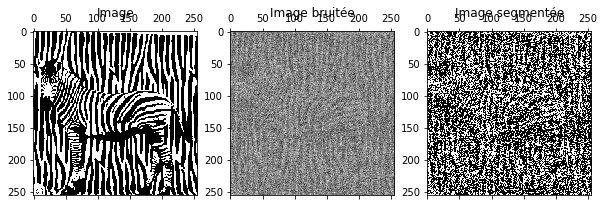

In [26]:
for j in range(3):
  seg_image_indep(ite, zebre, m1[j], sig1[j], m2[j], sig2[j])

#Modèle de Markov cachés

In [27]:
def gauss2(Y,n,m1,sig1,m2,sig2) :
  return np.array([norm.pdf(Y, m1, sig1), norm.pdf(Y, m2, sig2)])

In [28]:
def forward2(Mat_f, n, A, p10, p20):
  alpha = np.zeros((2, n))
  p = np.array([p10, p20])
  alpha[:, 0] = p * Mat_f[:, 0]
  alpha[:, 0] = alpha[:, 0] / (alpha[:, 0].sum())
  for i in range(1, n):
    alpha[:, i] = Mat_f[:,i]*(alpha[:,i-1]@A)
    alpha[:, i] = alpha[:, i] / (alpha[:, i].sum())
  return alpha

In [29]:
def backward2(Mat_f,n, A):
  beta = np.zeros((2, n))
  beta[:,n-1] = np.ones(2)
  for i in reversed(range(0, n-1)):
    beta[:, i] = (Mat_f[:,i+1]*beta[:,i+1])@np.transpose(A)
    beta[:, i] = beta[:, i] / (beta[:, i].sum())
  return beta

In [30]:
def calc_probatrans2(X, n, cl1,cl2):
  nbre1 = np.count_nonzero(X == cl1)
  nbre2 = X.size - nbre1
  p11, p22 = 0, 0
  for i in range(1,n):
    if X[i-1] == X[i]:
      if X[i] == cl1:
        p11 += 1
      else:
        p22 += 2
  p11 /= nbre1
  p22 /= nbre2
  A = np.array([[p11, 1-p11], [1-p22, p22]])
  return A

In [31]:
def MPM_chaines2(Mat_f,n,cl1,cl2,A,p10,p20):
  alpha = forward2(Mat_f, n, A, p10, p20)
  beta = backward2(Mat_f, n, A)
  tmp = alpha * beta
  epsilon = tmp/ np.sum(tmp)
  return np.where(epsilon[0,:] > epsilon[1, :], cl1, cl2)  

In [32]:
def calc_param_EM_mc(Y, A, p1, p2, m1, sig1, m2, sig2):
  N = Y.shape[0]
  Mat_f = gauss2(Y, N, m1, sig1, m2, sig2)
  alpha = forward2(Mat_f, N, A, p1, p2)
  beta = backward2(Mat_f, N, A)

  psi = np.empty((2,2, N-1))
  ksi = np.zeros((2,N))

  for n in range(N-1):
    for i in range(2):
      psi[i, :, n] = alpha[i, n] * A[i, :] * Mat_f[:, n+1] * beta [:, n+1]
    psi[:, :, n] = psi[:, :, n] / psi[:, :, n].sum()
  
  ksi[0, :] = abs(alpha[0, :]*beta[0, :])
  ksi[1, :] = abs(alpha[1, :]*beta[1, :])
  div = ksi[0, :] + ksi[1, :]
  ksi[0, :] = ksi[0, :] / div
  ksi[1, :] = ksi[1, :] / div

  p1 = ksi[0, :].sum() / N
  p2 = ksi[1, :].sum() / N

  for i in range(2):
    for j in range(2):
      A[i, j] = psi[i, j, :].sum() / ksi[i, :].sum()
  
  m1 = (ksi[0, :]*Y).sum() / ksi[0, :].sum() 
  m2 = (ksi[1, :]*Y).sum() / ksi[1, :].sum() 

  sig1 = np.sqrt(((Y-m1)**2 * ksi[0, :]).sum() / ksi[0, :].sum())
  sig2 = np.sqrt(((Y-m2)**2 * ksi[1, :]).sum() / ksi[1, :].sum())

  return A, p1, p2, m1, sig1, m2, sig2

In [38]:
def estim_param_EM_mc(iter, Y, A, p10, p20, m1, sig1, m2, sig2):
  A_est = A
  p10_est = p10
  p20_est = p20
  m1_est = m1
  sig1_est = sig1
  m2_est = m2
  sig2_est = sig2
  for i in range(iter):
    A_est, p10_est, p20_est, m1_est, sig1_est, m2_est, sig2_est = calc_param_EM_mc(Y, A, p10_est, p20_est, m1_est, sig1_est, m2_est, sig2_est)        
    #print({'A': A_est,'p10': p10_est,'p20': p20_est, 'm1': m1_est, 'sig1': sig1_est, 'm2': m2_est, 'sig2': sig2_est})
  return A_est, p10_est, p20_est, m1_est, sig1_est, m2_est, sig2_est


In [45]:
def Segmentation_image_mc(iter, imaj, m1, sig1, m2, sig2):
  counts, _ = np.histogram(imaj, bins=int(imaj.max()+1), range=(0,int(imaj.max())))
  cl1, cl2 = np.nonzero(counts)[0]
  tablal = peano_transform_img(imaj)
  tablal_bruit = bruit_gauss2(tablal, cl1, cl2, m1, sig1, m2, sig2)
  N = tablal.shape[0]
  p10, p20 = calc_probaprio2(tablal, cl1, cl2)
  trans = calc_probatrans2(tablal, N, cl1, cl2)

  kmeans = KMeans(n_clusters=2)
  kmeans.fit(tablal_bruit.reshape(-1,1))
  imaj_segment = kmeans.labels_
  moyennes = kmeans.cluster_centers_
  X0 = tablal_bruit[imaj_segment==0]
  X1 = tablal_bruit[imaj_segment==1]
  n0 = X0.shape[0]
  n1 = X1.shape[0]
  mom2 = np.array([(1/n0) * np.sum(X0**2), (1/n1) * np.sum(X1**2)])
  sigs = np.array([np.sqrt(mom2[0] - moyennes[0]), np.sqrt(mom2[1] - moyennes[1])])
  
  A_est, p1_est, p2_est, m1_est, sig1_est, m2_est, sig2_est = estim_param_EM_mc(iter, 
                                                                         tablal_bruit,
                                                                         trans,
                                                                         p10, p20, 
                                                                         moyennes[0][0], sigs[0], 
                                                                         moyennes[1][0], sigs[1])
  Mat_f_bruit = gauss2(tablal_bruit, N, m1_est, sig1_est, m2_est, sig2_est)
  segmented_tbl_ligne = MPM_chaines2(Mat_f_bruit, N, cl1, cl2, A_est, p1_est, p2_est)

  segmented_img = transform_peano_in_img(segmented_tbl_ligne, imaj.shape[0])
  bruited_img = transform_peano_in_img(tablal_bruit, imaj.shape[0])
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
  axes[0].matshow(imaj,cmap='gray')
  axes[0].set_title('Image')
  axes[2].matshow(segmented_img,cmap='gray')
  axes[2].set_title('Image segmentée')
  axes[1].matshow(bruited_img,cmap='gray')
  axes[1].set_title('Image bruitée')

  print("Taux d'erreur entre l'image réelle et l'image segmentée = "+str(taux_erreur(tablal,segmented_tbl_ligne)))


In [41]:
ite = 12

Taux d'erreur entre l'image réelle et l'image segmentée = 0.01019287109375
Taux d'erreur entre l'image réelle et l'image segmentée = 0.01275634765625
Taux d'erreur entre l'image réelle et l'image segmentée = 0.9778900146484375


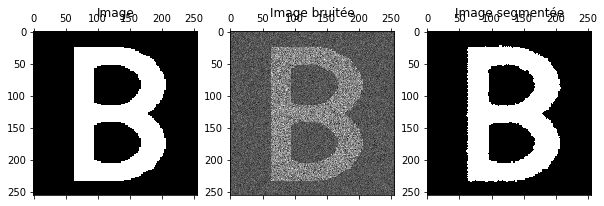

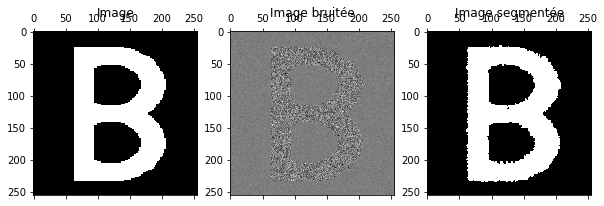

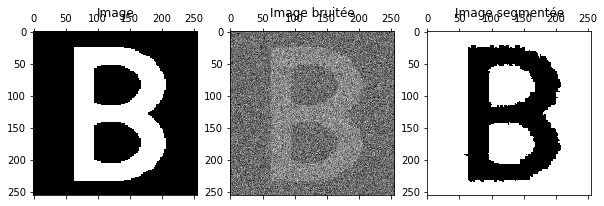

In [46]:
for j in range(3):
  Segmentation_image_mc(ite, beee, m1[j], sig1[j], m2[j], sig2[j])

Taux d'erreur entre l'image réelle et l'image segmentée = 0.9763336181640625
Taux d'erreur entre l'image réelle et l'image segmentée = 0.0273895263671875
Taux d'erreur entre l'image réelle et l'image segmentée = 0.946319580078125


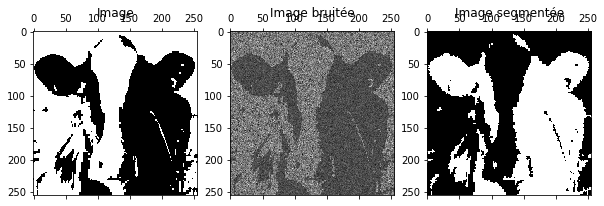

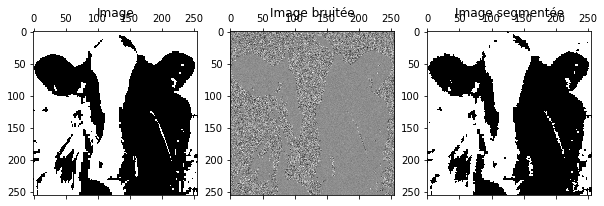

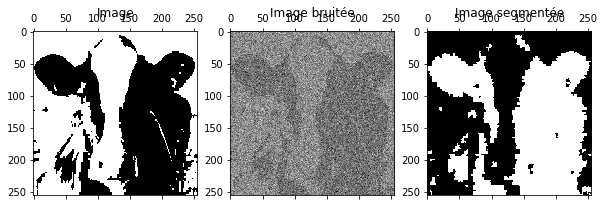

In [47]:
for j in range(3):
  Segmentation_image_mc(ite, veau, m1[j], sig1[j], m2[j], sig2[j])

Taux d'erreur entre l'image réelle et l'image segmentée = 0.9141387939453125
Taux d'erreur entre l'image réelle et l'image segmentée = 0.097320556640625
Taux d'erreur entre l'image réelle et l'image segmentée = 0.2603759765625


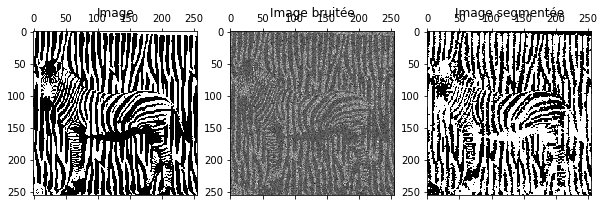

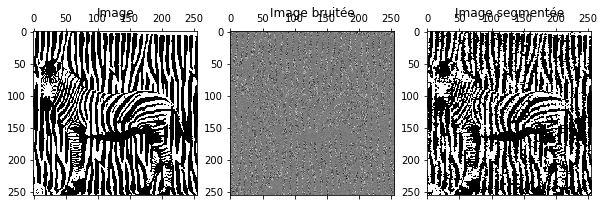

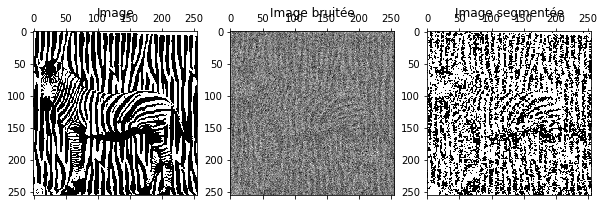

In [48]:
for j in range(3):
  Segmentation_image_mc(ite, zebre, m1[j], sig1[j], m2[j], sig2[j])